# One-Stage Kyle Model ($N=1$)

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

import plotly
from IPython.display import display, HTML

plotly.offline.init_notebook_mode()
display(
    HTML(
        '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
    )
)  # for latex in plotly labels

random_seed = 42

In [ ]:
asset_mean = 100.0
asset_stdev = 2.5
uninf_stdev = 5.0

# for lambda surface and plots
asset_stdevs = np.arange(0.5, 5.01, 0.1)
uninformed_stdevs = np.arange(2.0, 10.1, 0.1)

## Lambda Calculation

Experiment setup: generate true value of an asset with the same mean but different standard deviations, from small to large. These are $p_0$ and $\sqrt\Sigma_0$ from the theorem. Uninformed traders have order flow with mean $0$ and stdev $\sigma_u$.

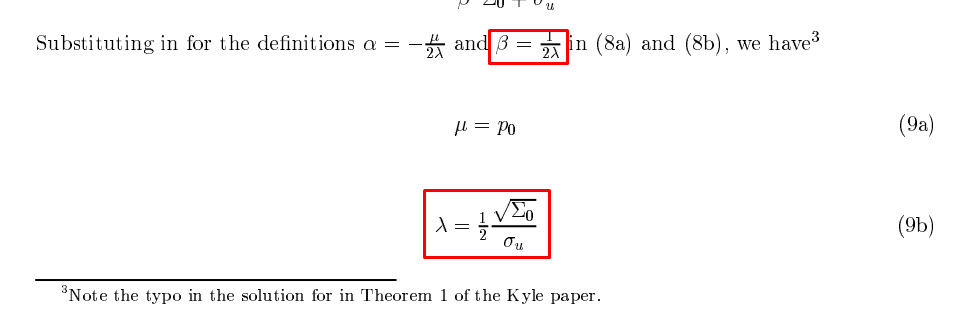

In [ ]:
def get_kyle1_params(
    true_asset_stdev: float, uninf_stdev: float
) -> tuple[float, float]:
    lmbd = true_asset_stdev / (2 * uninf_stdev)
    beta = 1 / (2 * lmbd)

    return lmbd, beta


def get_kyle1_lambda(asset_stdev, uninf_stdev):
    return asset_stdev / (2 * uninf_stdev)


def get_kyle1_quotes(
    guess_price: float,
    market_maker_spread: float,
    true_asset_value: float,
    true_asset_stdev: float,
    uninf_stdev: float,
    iterations=100,
):
    order_flow = []

    market_maker_quotes = [
        (guess_price + market_maker_spread, guess_price - market_maker_spread)
    ]

    lmbd, beta = get_kyle1_params(true_asset_stdev, uninf_stdev)

    for _ in range(iterations):
        midprice = (market_maker_quotes[-1][0] + market_maker_quotes[-1][1]) / 2

        uninformed_trader_of = np.random.normal(0, uninf_stdev)

        informed_trader_of = beta * (true_asset_value - midprice)

        total_order_flow = uninformed_trader_of + informed_trader_of

        # update market maker quotes
        last_bid = market_maker_quotes[-1][0]
        last_ask = market_maker_quotes[-1][1]

        price_adjustment = lmbd * total_order_flow

        new_bid, new_ask = last_bid + price_adjustment, last_ask + price_adjustment

        order_flow.append(total_order_flow)
        market_maker_quotes.append((new_bid, new_ask))

    return market_maker_quotes, lmbd, beta

In [ ]:
np.random.seed(random_seed)

n_iters = 50

true_asset_value = np.random.normal(asset_mean, asset_stdev)
market_maker_quotes, lmbd, beta = get_kyle1_quotes(
    110, 2, true_asset_value, asset_stdev, uninf_stdev, n_iters
)

bids = [x[0] for x in market_maker_quotes]
asks = [x[1] for x in market_maker_quotes]

# plot bids and asks

kyle1m_fig = go.Figure()

kyle1m_fig.add_trace(
    go.Scatter(x=list(range(n_iters)), y=bids, mode="lines+markers", name="Bids")
)
kyle1m_fig.add_trace(
    go.Scatter(x=list(range(n_iters)), y=asks, mode="lines+markers", name="Asks")
)
kyle1m_fig.add_hline(
    y=true_asset_value,
    line_dash="dot",
    yanchor="top",
    annotation_text=f"True asset value: {true_asset_value:.2f}",
    annotation_position="bottom right",
)

kyle1m_fig.show()

Surface of lambdas:

In [ ]:
assets_x, uninfs_y = np.meshgrid(asset_stdevs, uninformed_stdevs)
lmbd_z = get_kyle1_lambda(assets_x, uninfs_y)

lmbd_fig = go.Figure(
    go.Surface(x=assets_x, y=uninfs_y, z=lmbd_z, colorbar_thickness=24)
)

lmbd_fig.update_layout(
    title=dict(text="Lambda Surface"),
    width=600,
    height=600,
    font_size=12,
    scene=dict(
        xaxis=dict(title="Asset StDev"),
        yaxis=dict(title="Uninformed StDev"),
        zaxis=dict(title="Lambda"),
    ),
)

lmbd_fig.show()

## Other Adjustment Functions

# Multi-Period Kyle Model (N = 3)

At every iteration, for each period, solve cubic equation (take the second largest root):

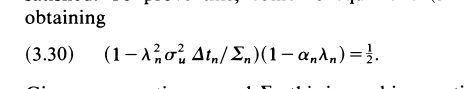

Expanded:

$$
\dfrac{\alpha_n \sigma_u^2 \Delta t}{\Sigma_n}\lambda_n^3 - \dfrac{\sigma_u^2 \Delta t}{\Sigma_n}\lambda_n^2 - \alpha_n\lambda_n + \dfrac{1}{2} = 0
$$

System of difference equations:

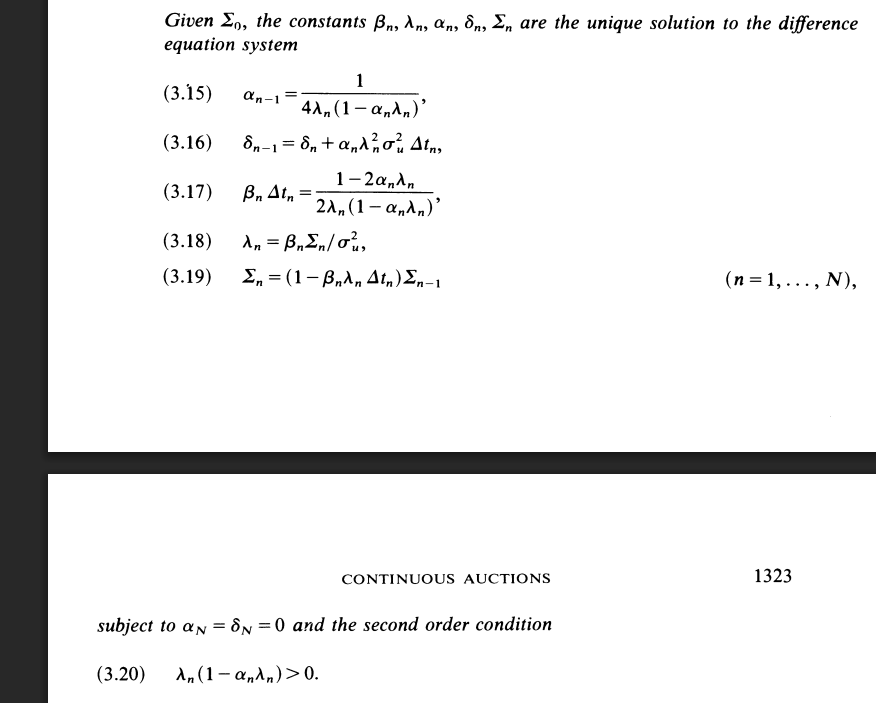

In [ ]:
from scipy.optimize import root_scalar


class MultiPeriodKyleModel:
    def __init__(self, N: int, apriori_stdev: float, uninf_stdev: float):
        self.dt = 1 / N
        self.uninf_stdev = uninf_stdev
        self.apriori_stdev = apriori_stdev
        self.N = N

    def fit(self, xtol: float = 1e-6, is_silent=True):

        root_results = root_scalar(
            self._perform_one_run,
            method='bisect',
            bracket=[1e-6, self.apriori_stdev],
            xtol=xtol,
            args=(is_silent,),
        )

        if not is_silent:
            print(f"apriori stdev: true={self.apriori_stdev}, fit={self.SIGMA_0}")

        return self

    def _init_params(self, final_stdev_guess: float):
        self.ALPHA = np.zeros(self.N)
        self.BETA = np.zeros(self.N)
        self.LAMBDA = np.zeros(self.N)
        self.SIGMA = np.zeros(self.N)

        self.SIGMA[self.N - 1] = final_stdev_guess**2

    def _perform_one_run(self, final_stdev_guess: float, is_silent: bool):
        self._init_params(final_stdev_guess)

        for n in range(self.N - 1, -1, -1):
            lmbd_roots = np.roots(
                [
                    self.ALPHA[n] * self.uninf_stdev**2 * self.dt / self.SIGMA[n] ** 2,
                    -self.uninf_stdev**2 * self.dt / self.SIGMA[n] ** 2,
                    -self.ALPHA[n],
                    0.5,
                ]
            )

            if (
                len(lmbd_roots) < 3
            ):  # if alpha=0, then we have two roots, positive and negative
                self.LAMBDA[n] = max(lmbd_roots)
            else:
                self.LAMBDA[n] = np.median(
                    lmbd_roots
                )  # the second largest, out of three, according to the paper

            # use lambda to calculate beta, and next step alpha and sigma
            self.BETA[n] = self.LAMBDA[n] * self.uninf_stdev**2 / self.SIGMA[n] ** 2

            if n > 0:
                self.SIGMA[n - 1] = self.SIGMA[n] / (
                    1 - self.BETA[n] * self.LAMBDA[n] * self.dt
                )
                self.ALPHA[n - 1] = 1 / (
                    4 * self.LAMBDA[n] * (1 - self.ALPHA[n] * self.LAMBDA[n])
                )
            else:
                self.SIGMA_0 = self.SIGMA[n] / (
                    1 - self.BETA[n] * self.LAMBDA[n] * self.dt
                )

        if not is_silent:
            print(f"current Sigma_0={self.SIGMA_0}, apriori={self.apriori_stdev}")
            print(f"beta={self.BETA}, sigma={self.SIGMA}, lambda={self.LAMBDA}")

        return self.SIGMA_0 - self.apriori_stdev

In [ ]:
kyle_periods = 3

kyle3_model = MultiPeriodKyleModel(kyle_periods, asset_stdev, uninf_stdev).fit(
    is_silent=False
)

In [ ]:
lmbd_by_uninf = [[] for _ in range(kyle_periods)]
beta_by_uninf = [[] for _ in range(kyle_periods)]
sigma_by_uninf = [[] for _ in range(kyle_periods)]

for u_std in uninformed_stdevs:
    kyle3_model = MultiPeriodKyleModel(kyle_periods, asset_stdev, u_std).fit()

    for param_n, (lmbd, beta, sigma) in enumerate(
        zip(kyle3_model.LAMBDA, kyle3_model.BETA, kyle3_model.SIGMA)
    ):
        lmbd_by_uninf[param_n].append(lmbd)
        beta_by_uninf[param_n].append(beta)
        sigma_by_uninf[param_n].append(sigma)

In [ ]:
def plot_kyle3_parameters(
    x_data, params_data, x_data_name: str, param_name: str, plot_title: str
):
    kyle3_fig = go.Figure()

    for param_n, vals in enumerate(params_data):
        kyle3_fig.add_trace(
            go.Scatter(x=x_data, y=vals, mode="lines+markers", name=f"n={param_n+1}")
        )

    kyle3_fig.update_layout(
        title=dict(text=plot_title),
        xaxis=dict(title=dict(text=x_data_name)),
        yaxis=dict(title=dict(text=param_name)),
    )
    kyle3_fig.show()

    return kyle3_fig

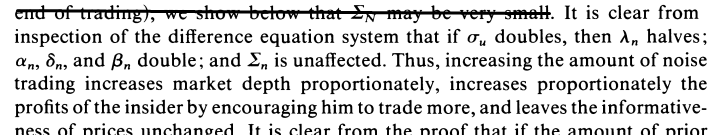

In [ ]:
plot_kyle3_parameters(
    uninformed_stdevs, lmbd_by_uninf, r"$\sigma_u$", r"$\lambda$", "Depth of the Market"
)
plot_kyle3_parameters(
    uninformed_stdevs,
    beta_by_uninf,
    r"$\sigma_u$",
    r"$\beta$",
    "Insider Trading Intensity",
)
plot_kyle3_parameters(
    uninformed_stdevs,
    sigma_by_uninf,
    r"$\sigma_u$",
    r"$\Sigma$",
    f"Insider Information, a priori={asset_stdev}",
)